In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import skimage as ski
import skimage.io

In [129]:
A = ski.io.imread('data/test/lena.png')
B = ski.io.imread('data/test/barbara.png')

'''
Función de conveniencia para manejar el overflow de una operación sobre una imágen
'''
def imfix(X, **kwargs):
    parameters = {
        'overflow': 'cap',
        'overflow_max': 255,
        'dtype': np.uint8,
    }
    
    parameters.update(kwargs)
    if parameters['overflow'] == 'cap':
        assert 'overflow_max' in parameters
        return np.minimum(X, parameters['overflow_max']).astype(parameters['dtype'])
    elif parameters['overflow'] == 'mod':
        assert 'overflow_max' in parameters
        return np.mod(X, parameters['overflow_max']).astype(parameters['dtype'])
    elif parameters['overflow'] == 'floor':
        return np.floor(X).astype(parameters['dtype'])
    elif parameters['overflow'] == 'ceil':
        return np.ceil(X).astype(parameters['dtype'])

# Ejercicio 1

In [130]:
'''
Suma de imágenes punto a punto
'''
def imsum(A, B, **kwargs):
    assert A.shape == B.shape
    return imfix(np.sum([A, B], axis=0, dtype=np.double), **kwargs)

'''
Producto de una imágen por un escalar, u otra imágen punto a punto
'''
def improd(alpha, A, **kwargs):
    return imfix(np.multiply(alpha, A, dtype=np.double), **kwargs)

'''
Compresión de rango dinámico
'''
def dynrange(A, L = 256, **kwargs):
    # Utilizamos 1 + R porque R puede ser 0, y el logarítmo no está definido en 0
    c = float(L - 1) / np.log(1 + np.max(A))
    return imfix(c * np.log(1 + A), **kwargs)

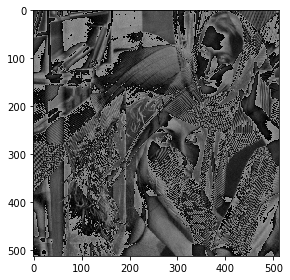

In [131]:
ski.io.imshow(imsum(A, B, overflow='mod', overflow_max=150))

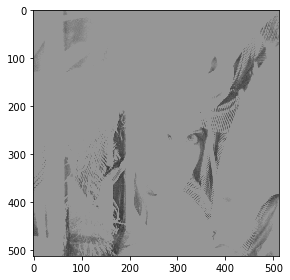

In [132]:
ski.io.imshow(imsum(A, B, overflow='cap', overflow_max=150))

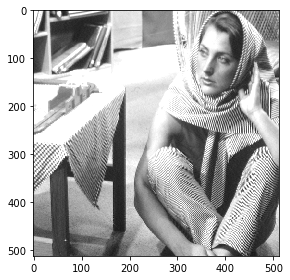

In [133]:
ski.io.imshow(improd(1.42, B, overflow='cap', overflow_max=255))

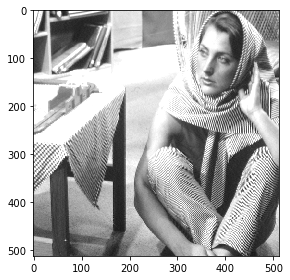

In [134]:
ski.io.imshow(improd(1.42 * np.ones((512, 512)), B, overflow='cap', overflow_max=255))

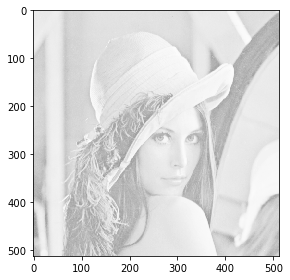

In [135]:
ski.io.imshow(dynrange(A))

# Ejercicio 2

In [136]:
'''
Negativo de una imágen
'''
def imneg(A, max_value=255, **kwargs):
    return imfix(max_value - A, **kwargs)

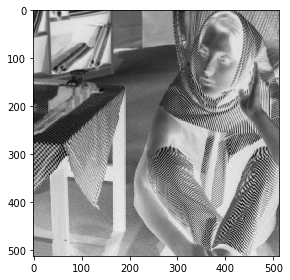

In [137]:
ski.io.imshow(imneg(B))

# Ejercicio 3

In [138]:
'''
Binarización de una imágen utilizando un umbral
'''
def imbinarize(A, threshold=128, max_value=255, min_value=0, **kwargs):
    X = np.copy(A)
    indexes = X > threshold
    X[indexes] = max_value
    X[np.invert(indexes)] = min_value
    return imfix(X, **kwargs)

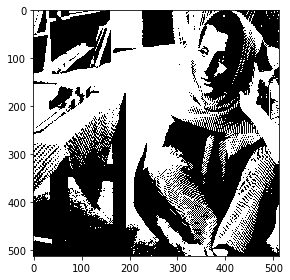

In [139]:
ski.io.imshow(imbinarize(B, 120))

# Ejercicio 4

In [140]:
'''
División de una imágen en los planos de cada bit
'''
def imbits(A):
    # Los elementos de este arreglo son 0 o 1
    X = np.unpackbits(A.reshape((A.shape[0], A.shape[1], 1)), axis=2)
    ims = []
    for i in range(8):
        # Binarizamos la imágen para poder ver la diferencia
        ims.append(imbinarize(X[:,:,i], threshold=0))
    return np.array(ims)

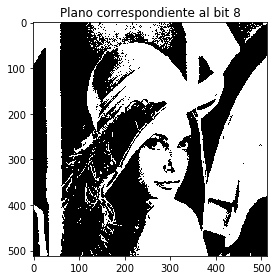

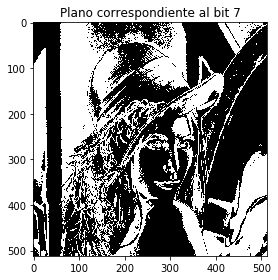

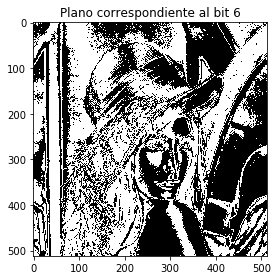

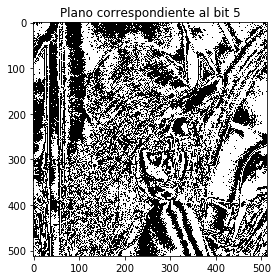

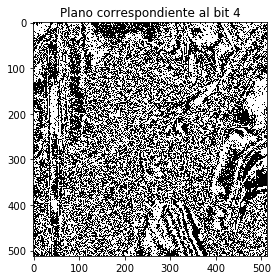

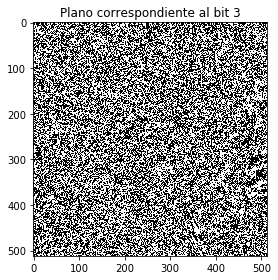

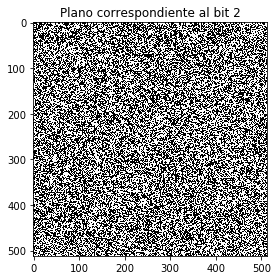

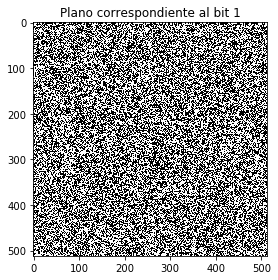

In [141]:
for index, im in enumerate(imbits(A)):
    plt.figure()
    plt.title('Plano correspondiente al bit ' + str(8 - index))
    ski.io.imshow(im)

# Ejercicio 5

In [147]:
'''
Computa un arreglo de cantidad de píxeles para cada brillo
'''
def imcountarr(A):
    # Usamos uint64, porque es un conteo de número de píxeles
    counts = np.zeros(shape=(256,), dtype=np.uint64)
    for row in A:
        for element in row:
            counts[element] += 1
    return counts

'''
Computa un arreglo de frecuencias relativas para cada brillo
'''
def imrelfreq(A):
    return imcountarr(A).astype(np.double) / np.prod(A.shape, dtype=np.double)

'''
Dibuja el histograma de brillos
'''
def imhist(A):
    Ns = imrelfreq(A)
    plt.bar(np.arange(256), Ns, 1)
    plt.show()

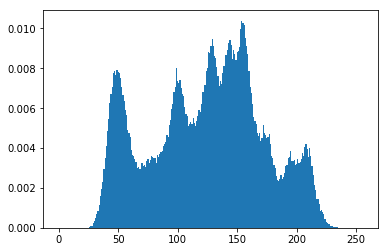

In [148]:
imhist(A)

# Ejercicios 6, 7, y 8

In [219]:
'''
Aplica una transformación de brillos T a una imágen A
'''
def imhisttrans(A, T):
    assert T.shape == (256,)
    return np.take(T, A)

'''
Computa un arreglo de sumas parciales de todos los índices menores.
'''
def cumhist(P):
    S = np.zeros(shape=(len(P),), dtype=np.double)
    cumulative = 0.0
    for i in range(len(P)):
        cumulative += P[i]
        S[i] = cumulative
    return S

'''
Computa un arreglo de sumas parciales de frecuencias relativas para todos los brillos. Es decir, la función de distribución acumulada.
'''
def imcumrelfreq(A):
    Ns = imrelfreq(A)
    return cumhist(imrelfreq(A))

'''
Dibuja el histograma de la función de distribución acumulada para los brillos
'''
def imcumhist(A):
    Hs = imcumrelfreq(A)
    plt.bar(np.arange(256), Hs, 1)
    plt.ylim((0.0, 1.0))
    plt.show()

'''
Linearización de histogramas
'''
def imaucontrast(A, L=256):
    T = (L - 1) * imcumrelfreq(A)
    T = np.floor(T)
    return imhisttrans(A, T).astype(np.uint8)

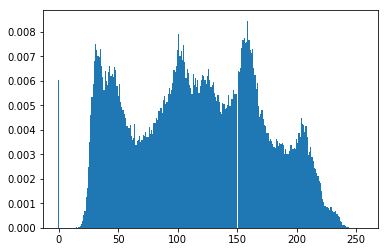

In [220]:
T = np.arange(256)
T[150] = 0
imhist(imhisttrans(B, T))

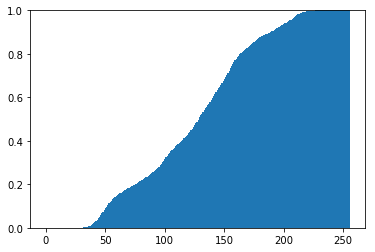

In [218]:
imcumhist(A)

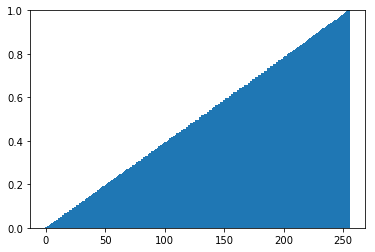

In [157]:
imcumhist(imaucontrast(A))

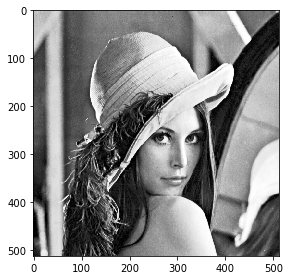

In [152]:
ski.io.imshow(imaucontrast(A))

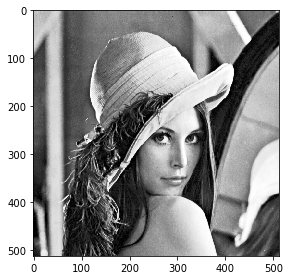

In [98]:
ski.io.imshow(imaucontrast(imaucontrast(A)))

# Ejercicio 9

In [235]:
'''
Convierte el histograma de brillos de `A en el histograma de brillos acumulado especificado por `E`
'''
def imspecmatching(A, E):
    assert len(E) == 256
    assert E[-1] == 1.0
    
    # CDF real de los brillos de la imágen
    R = imcumrelfreq(A)
    T = np.zeros(256, dtype=np.uint8)
    for g1 in range(256):
        for g2 in range(256):
            if E[g2] >= R[g1]:
                T[g1] = g2
                break
    return imhisttrans(A, T)

'''
Ecualiza el histograma de A en una normal con media `mean` y desvío standard `stddev`
'''
def imspecnorm(A, mean, stddev):
    # CDF esperada de los brillos de la imágen
    E = sps.norm.cdf(np.arange(256), loc=mean, scale=stddev)
    return imspecmatching(A, E)

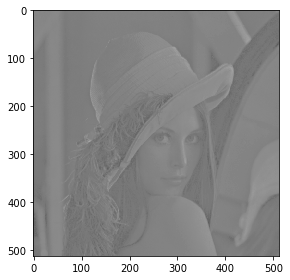

In [236]:
ski.io.imshow(imspecnorm(A, 128, 8))

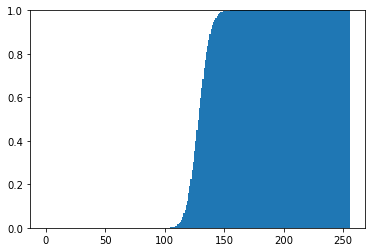

In [237]:
imcumhist(imspecnorm(A, 128, 8))

# Ejercicio 10

In [243]:
def imresidualhist(A, lam):
    if lam == 0.0:
        return imaucontrast(A)
    
    U = sps.uniform.cdf(np.arange(256), loc=0, scale=255)
    H0 = imcumrelfreq(A)
    E = (H0 + lam * U) / (1 + lam)
    return imspecmatching(A, E)

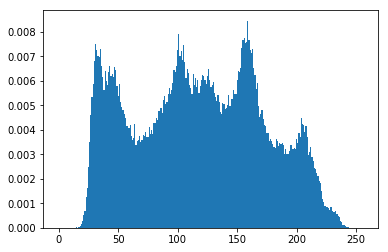

In [244]:
imhist(B)

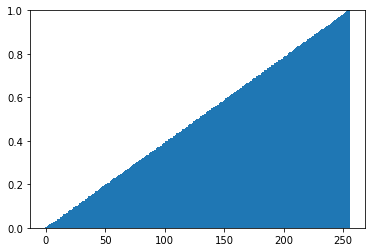

In [251]:
imcumhist(imresidualhist(B, 0.0))

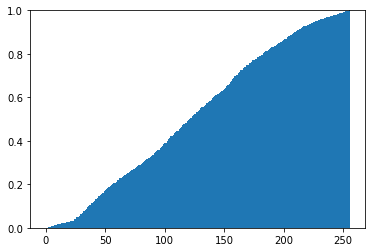

In [252]:
imcumhist(imresidualhist(B, 0.7))

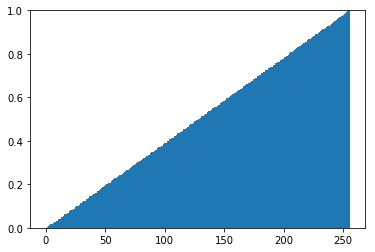

In [253]:
imcumhist(imresidualhist(B, 1000))